<a href="https://colab.research.google.com/github/shashwat0070/Anomaly-project/blob/main/Anomoly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
import pandas as pd

# Kaggle: Store Item Demand Forecasting
# https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

# Or use this quick synthetic data generator:
import numpy as np
from datetime import datetime, timedelta

# Generate 6 months of daily data
dates = pd.date_range(start='2024-01-01', end='2024-06-30', freq='D')
n = len(dates)

# Create realistic traffic pattern
np.random.seed(42)
trend = np.linspace(1000, 1500, n)  # Growth trend
weekly = 200 * np.sin(2 * np.pi * np.arange(n) / 7)  # Weekly seasonality
noise = np.random.normal(0, 50, n)  # Random noise

traffic = trend + weekly + noise

# Add some anomalies manually
traffic[45] = traffic[45] * 0.5  # Drop on day 45
traffic[90] = traffic[90] * 1.8  # Spike on day 90
traffic[130:135] = traffic[130:135] * 0.6  # Multi-day drop

df = pd.DataFrame({
    'date': dates,
    'traffic': traffic.astype(int),
    'is_weekend': dates.dayofweek.isin([5, 6]).astype(int),
    'day_of_week': dates.dayofweek,
    'month': dates.month
})

df.to_csv('traffic_data.csv', index=False)
print(df.head())

        date  traffic  is_weekend  day_of_week  month
0 2024-01-01     1024           0            0      1
1 2024-01-02     1152           0            1      1
2 2024-01-03     1232           0            2      1
3 2024-01-04     1171           0            3      1
4 2024-01-05      912           0            4      1


                      date      traffic  is_weekend  day_of_week       month
count                  182   182.000000  182.000000   182.000000  182.000000
mean   2024-03-31 12:00:00  1235.862637    0.285714     3.000000    3.500000
min    2024-01-01 00:00:00   587.000000    0.000000     0.000000    1.000000
25%    2024-02-15 06:00:00  1057.000000    0.000000     1.000000    2.000000
50%    2024-03-31 12:00:00  1239.000000    0.000000     3.000000    3.500000
75%    2024-05-15 18:00:00  1395.750000    1.000000     5.000000    5.000000
max    2024-06-30 00:00:00  1974.000000    1.000000     6.000000    6.000000
std                    NaN   234.318779    0.453000     2.005517    1.713611
Date range: 2024-01-01 00:00:00 to 2024-06-30 00:00:00
Number of days: 182


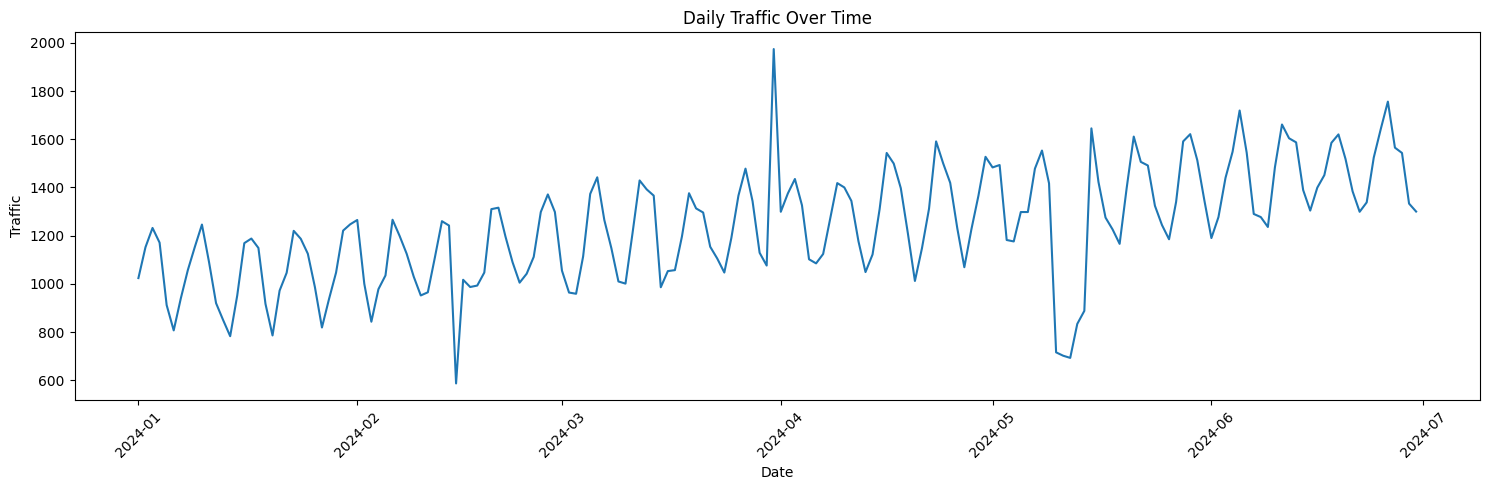

Missing values: date           0
traffic        0
is_weekend     0
day_of_week    0
month          0
dtype: int64


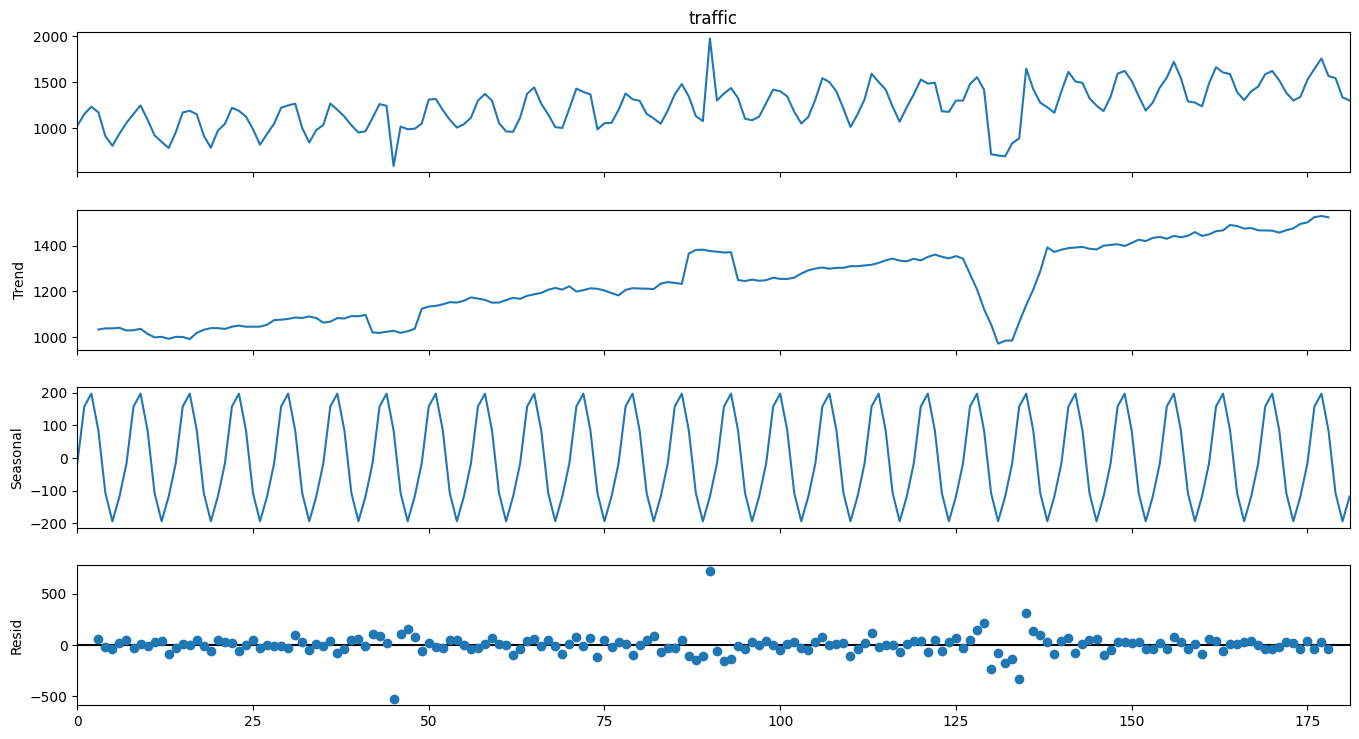

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('traffic_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Basic stats
print(df.describe())
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of days: {len(df)}")

# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(df['date'], df['traffic'])
plt.title('Daily Traffic Over Time')
plt.xlabel('Date')
plt.ylabel('Traffic')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('01_timeseries_plot.png')
plt.show()

# Check for missing values
print(f"Missing values: {df.isnull().sum()}")

# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['traffic'], model='additive', period=7)
fig = result.plot()
fig.set_size_inches(15, 8)
plt.savefig('02_decomposition.png')
plt.show()

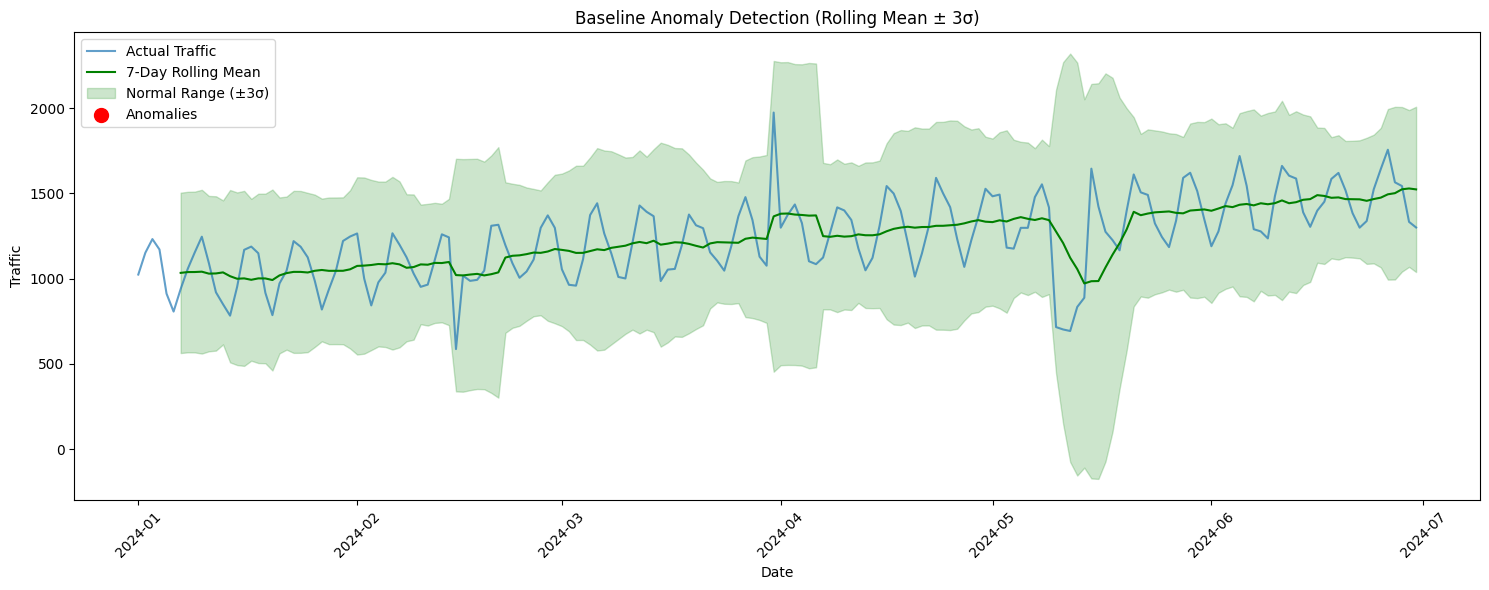

Anomalies detected: 0

Anomaly dates:
Empty DataFrame
Columns: [date, traffic, rolling_mean_7]
Index: []


In [ ]:
# Feature engineering
df['rolling_mean_7'] = df['traffic'].rolling(window=7, center=False).mean()
df['rolling_std_7'] = df['traffic'].rolling(window=7, center=False).std()

# Define anomaly threshold (3 standard deviations)
df['upper_bound'] = df['rolling_mean_7'] + 3 * df['rolling_std_7']
df['lower_bound'] = df['rolling_mean_7'] - 3 * df['rolling_std_7']

# Flag anomalies
df['is_anomaly_baseline'] = (
    (df['traffic'] > df['upper_bound']) |
    (df['traffic'] < df['lower_bound'])
).astype(int)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['traffic'], label='Actual Traffic', alpha=0.7)
plt.plot(df['date'], df['rolling_mean_7'], label='7-Day Rolling Mean', color='green')
plt.fill_between(df['date'], df['lower_bound'], df['upper_bound'],
                 alpha=0.2, color='green', label='Normal Range (±3σ)')

# Mark anomalies
anomalies = df[df['is_anomaly_baseline'] == 1]
plt.scatter(anomalies['date'], anomalies['traffic'],
           color='red', s=100, label='Anomalies', zorder=5)

plt.title('Baseline Anomaly Detection (Rolling Mean ± 3σ)')
plt.xlabel('Date')
plt.ylabel('Traffic')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('03_baseline_method.png')
plt.show()

print(f"Anomalies detected: {df['is_anomaly_baseline'].sum()}")
print("\nAnomaly dates:")
print(anomalies[['date', 'traffic', 'rolling_mean_7']])

In [ ]:
from prophet import Prophet


Fitting SARIMA model (this may take 1-2 minutes)...
Model fitted!


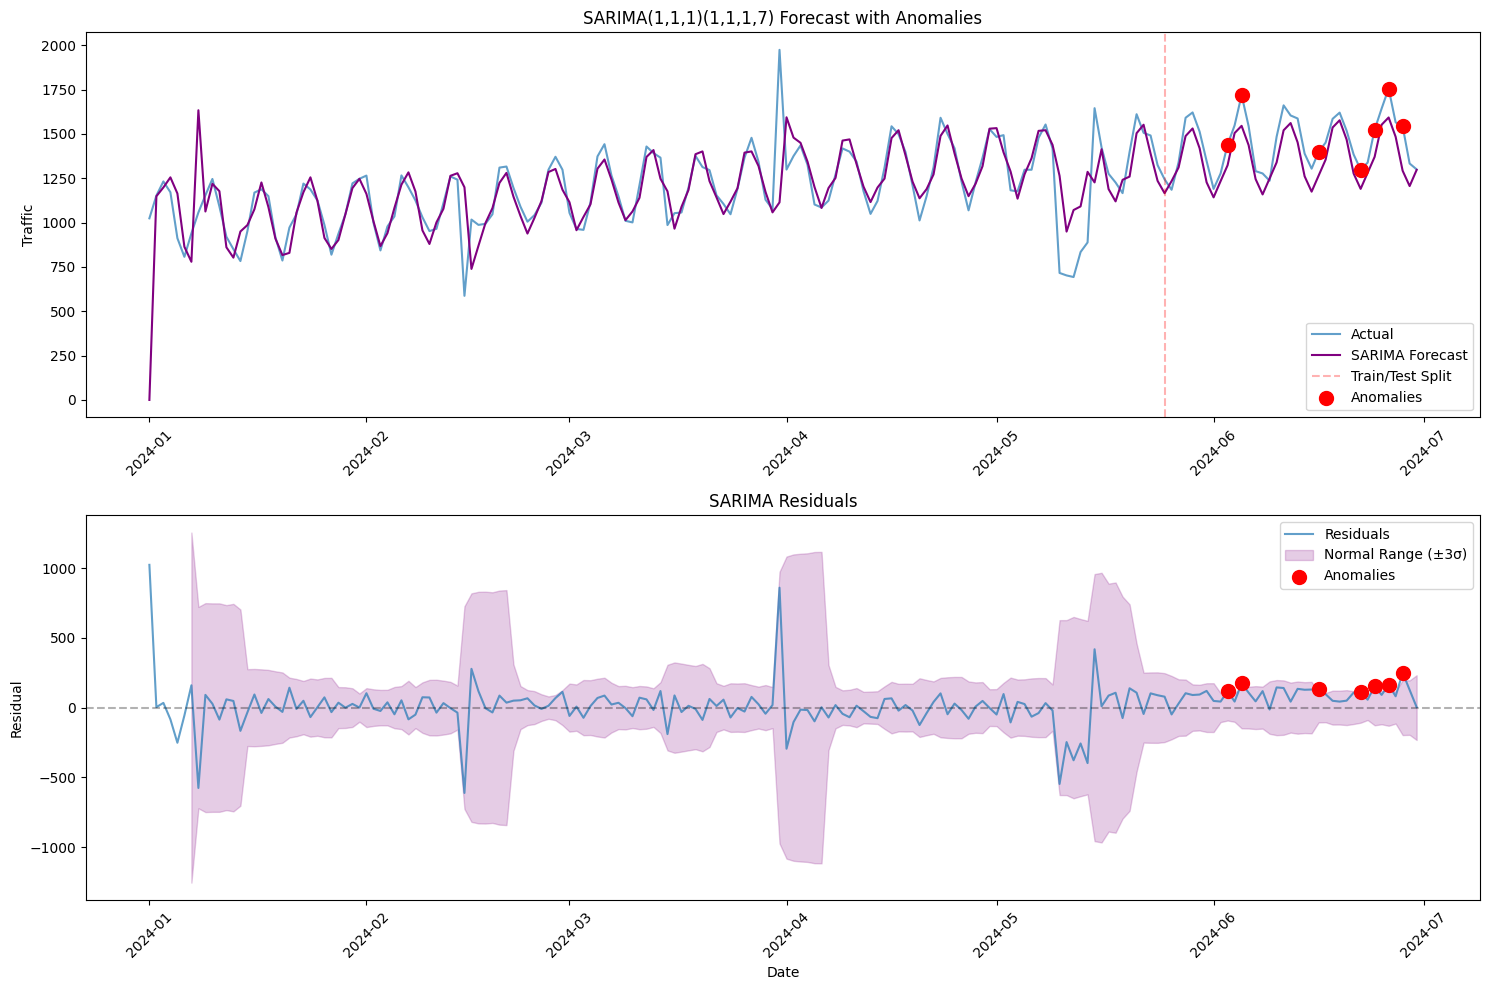


SARIMA anomalies detected: 7

Model Summary:
                                     SARIMAX Results                                     
Dep. Variable:                           traffic   No. Observations:                  145
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -820.352
Date:                           Sat, 22 Nov 2025   AIC                           1650.705
Time:                                   01:35:11   BIC                           1664.965
Sample:                                        0   HQIC                          1656.499
                                           - 145                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3648      0.081      4.526      0.000       0.207       0.5

In [ ]:
# PHASE 4 ALTERNATIVE: SARIMA (replaces Prophet)

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

# Prepare train/test split
split_idx = int(len(df) * 0.8)
train = df[:split_idx].copy()
test = df[split_idx:].copy()

# Fit SARIMA model
# SARIMA(p,d,q)(P,D,Q,s)
# p,d,q: non-seasonal AR, differencing, MA
# P,D,Q,s: seasonal AR, differencing, MA, period
print("Fitting SARIMA model (this may take 1-2 minutes)...")

model = SARIMAX(
    train['traffic'],
    order=(1, 1, 1),           # (p,d,q)
    seasonal_order=(1, 1, 1, 7),  # (P,D,Q,s) - weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)
print("Model fitted!")

# Make predictions for entire dataset
df['sarima_predicted'] = model_fit.predict(start=0, end=len(df)-1)

# For points after training, use forecast
forecast = model_fit.forecast(steps=len(test))
df.loc[test.index, 'sarima_predicted'] = forecast.values

# Calculate residuals
df['sarima_residual'] = df['traffic'] - df['sarima_predicted']
df['sarima_residual_std'] = df['sarima_residual'].rolling(window=7).std()

# Flag anomalies (residual > 3 standard deviations)
threshold = 3
df['is_anomaly_sarima'] = (
    abs(df['sarima_residual']) > threshold * df['sarima_residual_std']
).astype(int)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Forecast vs Actual
ax1.plot(df['date'], df['traffic'], label='Actual', alpha=0.7)
ax1.plot(df['date'], df['sarima_predicted'], label='SARIMA Forecast', color='purple')

# Shade train/test regions
ax1.axvline(x=df['date'].iloc[split_idx], color='red', linestyle='--', alpha=0.3, label='Train/Test Split')

anomalies_sarima = df[df['is_anomaly_sarima'] == 1]
ax1.scatter(anomalies_sarima['date'], anomalies_sarima['traffic'],
           color='red', s=100, label='Anomalies', zorder=5)
ax1.set_title('SARIMA(1,1,1)(1,1,1,7) Forecast with Anomalies')
ax1.set_ylabel('Traffic')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Residuals
ax2.plot(df['date'], df['sarima_residual'], label='Residuals', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.fill_between(df['date'],
                 -threshold * df['sarima_residual_std'],
                 threshold * df['sarima_residual_std'],
                 alpha=0.2, color='purple', label='Normal Range (±3σ)')
ax2.scatter(anomalies_sarima['date'], anomalies_sarima['sarima_residual'],
           color='red', s=100, label='Anomalies', zorder=5)
ax2.set_title('SARIMA Residuals')
ax2.set_xlabel('Date')
ax2.set_ylabel('Residual')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('04_sarima_method.png')
plt.show()

print(f"\nSARIMA anomalies detected: {df['is_anomaly_sarima'].sum()}")
print("\nModel Summary:")
print(model_fit.summary())


=== COMPARISON ===
Baseline detected: 0 anomalies
SARIMA detected: 7 anomalies
Ensemble (both agree) detected: 0 anomalies


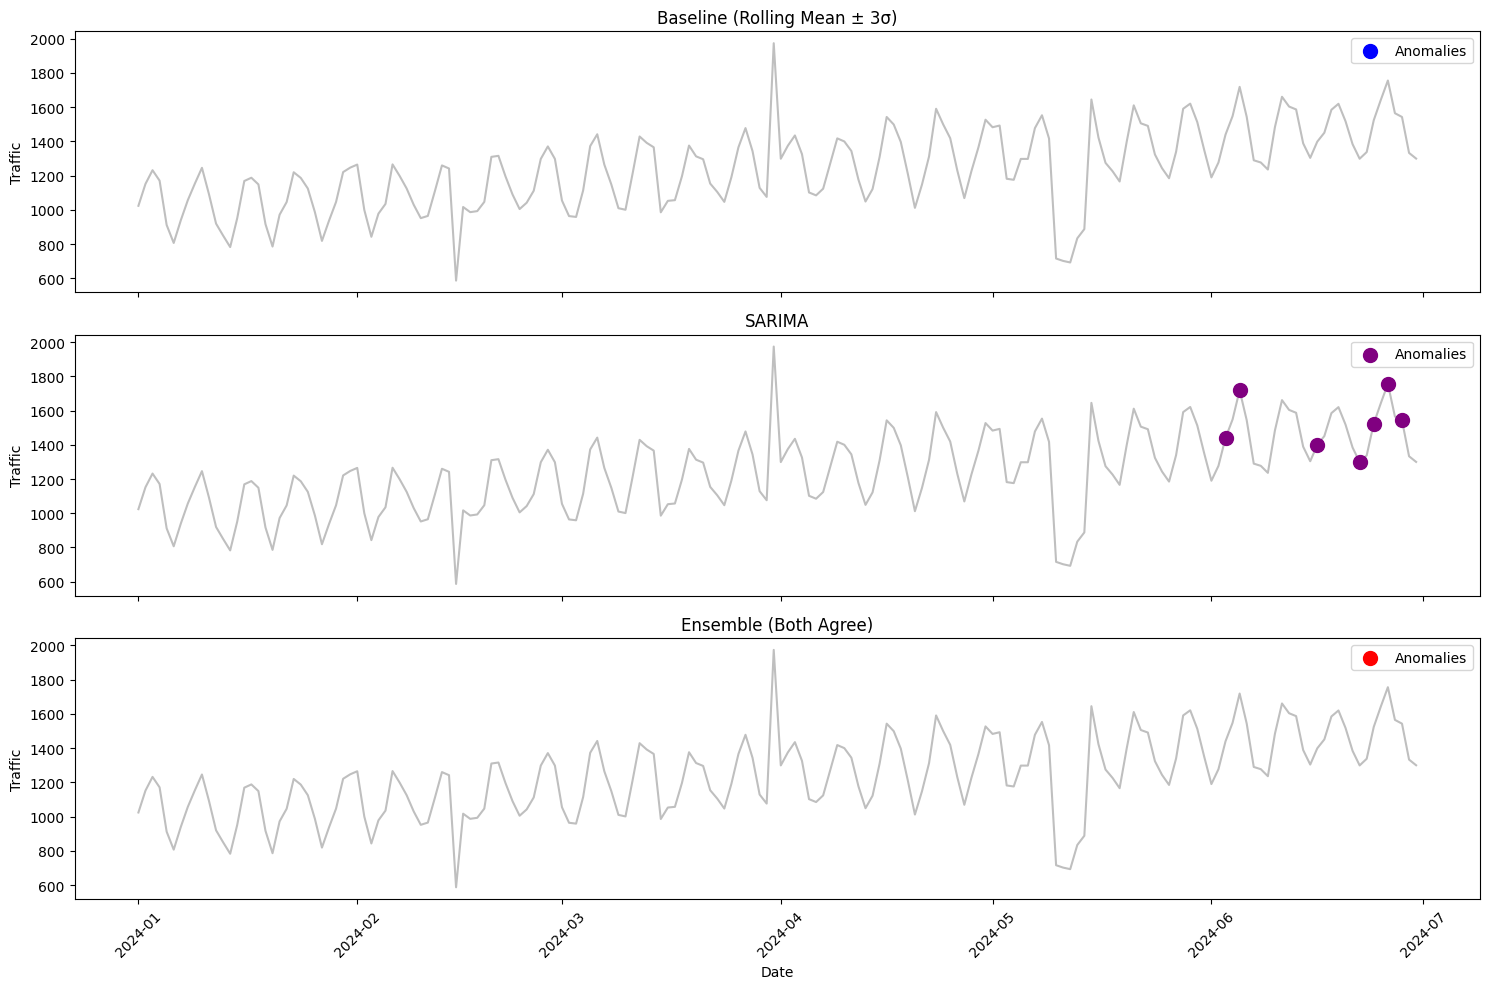

In [ ]:
# Compare only the methods you've run so far
df_results = df[['date', 'traffic', 'is_anomaly_baseline',
                 'is_anomaly_sarima']].copy()

# Create ensemble: flag as anomaly if BOTH methods agree
df_results['is_anomaly_ensemble'] = (
    (df_results['is_anomaly_baseline'] == 1) &
    (df_results['is_anomaly_sarima'] == 1)
).astype(int)

# Summary
print("\n=== COMPARISON ===")
print(f"Baseline detected: {df_results['is_anomaly_baseline'].sum()} anomalies")
print(f"SARIMA detected: {df_results['is_anomaly_sarima'].sum()} anomalies")
print(f"Ensemble (both agree) detected: {df_results['is_anomaly_ensemble'].sum()} anomalies")

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

methods = [
    ('is_anomaly_baseline', 'Baseline (Rolling Mean ± 3σ)', 'blue'),
    ('is_anomaly_sarima', 'SARIMA', 'purple'),
    ('is_anomaly_ensemble', 'Ensemble (Both Agree)', 'red')
]

for ax, (col, title, color) in zip(axes, methods):
    ax.plot(df_results['date'], df_results['traffic'], alpha=0.5, color='gray')
    anomalies = df_results[df_results[col] == 1]
    ax.scatter(anomalies['date'], anomalies['traffic'],
              color=color, s=100, label='Anomalies', zorder=5)
    ax.set_title(title)
    ax.set_ylabel('Traffic')
    ax.legend()
    if ax != axes[-1]:
        ax.set_xticklabels([])

axes[-1].set_xlabel('Date')
axes[-1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('06_method_comparison.png')
plt.show()

In [ ]:
# PHASE 5: Isolation Forest
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# First, make sure we have a clean copy without NaN values from SARIMA
df_clean = df.copy()

# Engineer features
df_clean['traffic_lag_1'] = df_clean['traffic'].shift(1)
df_clean['traffic_lag_7'] = df_clean['traffic'].shift(7)
df_clean['pct_change_1'] = df_clean['traffic'].pct_change(1)
df_clean['pct_change_7'] = df_clean['traffic'].pct_change(7)
df_clean['rolling_mean_7'] = df_clean['traffic'].rolling(7).mean()
df_clean['rolling_std_7'] = df_clean['traffic'].rolling(7).std()
df_clean['deviation_from_ma'] = df_clean['traffic'] - df_clean['rolling_mean_7']

# Drop rows with NaN (from lagging/rolling)
df_clean = df_clean.dropna().copy()

# Select features for model
feature_cols = [
    'traffic', 'traffic_lag_1', 'traffic_lag_7',
    'pct_change_1', 'pct_change_7',
    'rolling_mean_7', 'rolling_std_7',
    'deviation_from_ma',
    'day_of_week', 'is_weekend'
]

X = df_clean[feature_cols]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
print("Training Isolation Forest...")
iso_forest = IsolationForest(
    contamination=0.05,  # Expect 5% anomalies
    random_state=42,
    n_estimators=100
)

anomaly_scores = iso_forest.fit_predict(X_scaled)
df_clean['is_anomaly_iforest'] = (anomaly_scores == -1).astype(int)

# Merge back to original dataframe
df = df.merge(
    df_clean[['date', 'is_anomaly_iforest']],
    on='date',
    how='left'
)
df['is_anomaly_iforest'] = df['is_anomaly_iforest'].fillna(0).astype(int)

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['traffic'], label='Actual Traffic', alpha=0.7)

anomalies_iforest = df[df['is_anomaly_iforest'] == 1]
plt.scatter(anomalies_iforest['date'], anomalies_iforest['traffic'],
           color='green', s=100, label='Anomalies (Isolation Forest)', zorder=5)

plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Traffic')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('05_isolation_forest.png')
plt.show()

print(f"\nIsolation Forest anomalies detected: {df['is_anomaly_iforest'].sum()}")
print("\nAnomaly dates:")
print(anomalies_iforest[['date', 'traffic']])

Training Isolation Forest...


KeyError: 'is_anomaly_iforest'

In [ ]:
# NOW compare all 3 methods
df_results = df[['date', 'traffic', 'is_anomaly_baseline',
                 'is_anomaly_sarima', 'is_anomaly_iforest']].copy()

# Create ensemble: flag as anomaly if 2+ methods agree
df_results['ensemble_votes'] = (
    df_results['is_anomaly_baseline'] +
    df_results['is_anomaly_sarima'] +
    df_results['is_anomaly_iforest']
)
df_results['is_anomaly_ensemble'] = (df_results['ensemble_votes'] >= 2).astype(int)

# Summary
print("\n=== COMPARISON ===")
print(f"Baseline detected: {df_results['is_anomaly_baseline'].sum()} anomalies")
print(f"SARIMA detected: {df_results['is_anomaly_sarima'].sum()} anomalies")
print(f"Isolation Forest detected: {df_results['is_anomaly_iforest'].sum()} anomalies")
print(f"Ensemble detected: {df_results['is_anomaly_ensemble'].sum()} anomalies")

# Venn diagram style analysis
print("\n=== OVERLAP ANALYSIS ===")
baseline_only = ((df_results['is_anomaly_baseline'] == 1) &
                 (df_results['ensemble_votes'] == 1)).sum()
sarima_only = ((df_results['is_anomaly_sarima'] == 1) &
               (df_results['ensemble_votes'] == 1)).sum()
iforest_only = ((df_results['is_anomaly_iforest'] == 1) &
                (df_results['ensemble_votes'] == 1)).sum()
all_three = (df_results['ensemble_votes'] == 3).sum()

print(f"Detected by only 1 method: {baseline_only + sarima_only + iforest_only}")
print(f"Detected by 2 methods: {(df_results['ensemble_votes'] == 2).sum()}")
print(f"Detected by all 3 methods: {all_three}")


=== COMPARISON ===
Baseline detected: 0 anomalies
SARIMA detected: 7 anomalies
Isolation Forest detected: 9 anomalies
Ensemble detected: 0 anomalies

=== OVERLAP ANALYSIS ===
Detected by only 1 method: 16
Detected by 2 methods: 0
Detected by all 3 methods: 0


In [ ]:
ensemble = (baseline + sarima + iforest >= 2).astype(int)

NameError: name 'baseline' is not defined